In [1]:
import numpy as np
import time 
from matplotlib import pyplot as plt
import gpflow
import pandas as pd
from gpflow.ci_utils import ci_niter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from TensorNetworkKernels import KernelWithTensorNetwork, KernelSpaceInducingPoints
from sklearn.cluster import KMeans

In [2]:
X_full, Y_full = np.load('./data/electric/X.npy')[:100000], np.load('./data/electric/y.npy')[:100000]
x_train, x_test, y_train, y_test = train_test_split(X_full, Y_full, test_size = 0.1, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 0)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

x_train, x_val, x_test= scaler_X.fit_transform(x_train), scaler_X.transform(x_val), scaler_X.transform(x_test)
y_train, y_val, y_test = scaler_Y.fit_transform(y_train.reshape(-1,1)), scaler_Y.transform(y_val.reshape(-1,1)), scaler_Y.transform(y_test.reshape(-1,1))

In [3]:
x_train.shape

(81000, 6)

# CPD Kernel

In [4]:
cp_rank=10
local_dim=15
batch_size=256

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).batch(batch_size,
                                                                                            drop_remainder=True).repeat()

In [5]:
kernel = KernelWithTensorNetwork(gpflow.kernels.SquaredExponential(), batch_size=batch_size,
                                 cp_rank=cp_rank,local_dim=local_dim)

M=50 # inducing points 

# Cluster Initialization of Inducing Points # in this case we used the first 50 due to
# the long time of kmeans to converge in this large dataset 
inducing_variable_kmeans = KMeans(n_clusters=M,random_state=0).fit(x_train)   
Z=inducing_variable_kmeans.cluster_centers_                           
inducing_variable_CP = kernel.CP(Z)
inducing_variable = KernelSpaceInducingPoints(inducing_variable_CP)

# Z=x_train[:M,:].copy()                           
# inducing_variable_CP = kernel.CP(Z)
# inducing_variable = KernelSpaceInducingPoints(inducing_variable_CP)

model= gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable , num_data=x_train.shape[0])    
gpflow.set_trainable(model.inducing_variable, True)
model.kernel.CP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cp__based (CP_Based)         (50, 1)                   900       
Total params: 900
Trainable params: 900
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Epoch:0, ELBO:-155300.0110235725
Epoch:1000, ELBO:-53352.08139816983
Epoch:2000, ELBO:-10956.543222118857
Epoch:3000, ELBO:30833.044332959562
Epoch:4000, ELBO:68977.32657944907
Epoch:5000, ELBO:99945.22668011821
Epoch:6000, ELBO:118985.23112153412
Epoch:7000, ELBO:124927.20400122323
Epoch:8000, ELBO:126544.83809162743
Epoch:9000, ELBO:125306.040529097
Training Time :37.515608072280884
Train MSE:0.002444570006909252, Train ELBO:128098.33043777701
Validation MSE:0.0026800334910093092, Validation ELBO:124342.90104581852
Test MSE:0.0024726900729603123, Validation ELBO:127648.7500446313


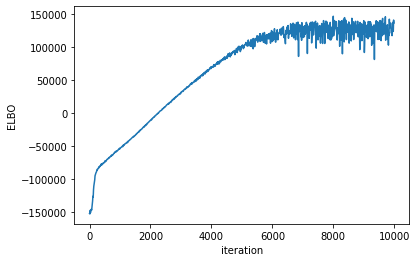

In [6]:
# Training
iterations = ci_niter(10000)

logf = []

train_iter=iter(train_dataset)
training_loss = model.training_loss_closure(train_iter,compile=True)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)
start=time.time()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
    
for step in range(iterations):
    optimization_step()    
    if step % 10 == 0:
        elbo = -training_loss().numpy()
        logf.append(elbo)
    if step % 1000==0:
        print("Epoch:{}, ELBO:{}".format(step,model.elbo(data=(x_train,y_train)))) 

end=time.time()
print("Training Time :{}".format(end-start))

plt.plot(np.arange(iterations)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

train_mean, train_var = model.predict_f(x_train) 
train_elbo=model.elbo(data=(x_train,y_train))

train_mse=tf.reduce_mean(tf.losses.MSE(train_mean,y_train))

val_mean, val_var = model.predict_f(x_val)
val_elbo = model.elbo(data=(x_val,y_val))

val_mse=tf.reduce_mean(tf.losses.MSE(val_mean,y_val))

test_mean, val_var = model.predict_f(x_test)
test_elbo = model.elbo(data=(x_test,y_test))

test_mse=tf.reduce_mean(tf.losses.MSE(test_mean,y_test))


print("Train MSE:{}, Train ELBO:{}".format(train_mse,train_elbo))
print("Validation MSE:{}, Validation ELBO:{}".format(val_mse,val_elbo))
print("Test MSE:{}, Validation ELBO:{}".format(test_mse,test_elbo))

# Tensor Network 

In [35]:
def local_feature_mapping(x_train,x_val,x_test,local_dim=2,unit_norm=False):
    
    n_train_samples = x_train.shape[0]
    n_val_samples = x_val.shape[0]
    n_test_samples = x_test.shape[0]
    n_features = x_train.shape[1]

    X_transformed_train_list = []
    X_transformed_val_list = []
    X_transformed_test_list = []
    
    for d in range(local_dim-1):
        X_transformed_train_list.append(x_train**(d+1))
        X_transformed_val_list.append(x_val**(d+1))
        X_transformed_test_list.append(x_test**(d+1))
         
    X_stand_train_list = [np.ones((n_train_samples,n_features))]
    X_stand_val_list = [np.ones((n_val_samples,n_features))]
    X_stand_test_list = [np.ones((n_test_samples,n_features))]
    
    for X_trans_train,X_trans_val,X_trans_test in zip(X_transformed_train_list,X_transformed_val_list,X_transformed_test_list):
         
      X_stand_train_list.append(X_trans_train)
      X_stand_val_list.append(X_trans_val) 
      X_stand_test_list.append(X_trans_test)
        
    x_train_processed= np.transpose(X_stand_train_list,(1, 2, 0))
    x_val_processed= np.transpose(X_stand_val_list,(1, 2, 0))
    x_test_processed = np.transpose(X_stand_test_list,(1, 2, 0))

    if(unit_norm==True):
      norms_train = np.sqrt(np.sum(x_train_processed**2,axis=-1,keepdims=True))
      x_train_processed = np.divide(x_train_processed,norms_train)

      norms_val = np.sqrt(np.sum(x_val_processed**2,axis=-1,keepdims=True))
      x_val_processed = np.divide(x_val_processed,norms_val)
    
      norms_test = np.sqrt(np.sum(x_test_processed**2,axis=-1,keepdims=True))
      x_test_processed = np.divide(x_test_processed,norms_test)

    return x_train_processed, x_val_processed, x_test_processed      


Epoch 1/100
317/317 [==============================] - 1s 2ms/step - loss: 0.5264 - val_loss: 0.1435
Epoch 2/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0739 - val_loss: 0.0328
Epoch 3/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0232 - val_loss: 0.0160
Epoch 4/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0104
Epoch 5/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0091 - val_loss: 0.0078
Epoch 6/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 7/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 8/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 9/100
317/317 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 10/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0043 - val_lo

317/317 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 82/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 83/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 84/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 85/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 86/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 87/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 88/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 89/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 90/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 

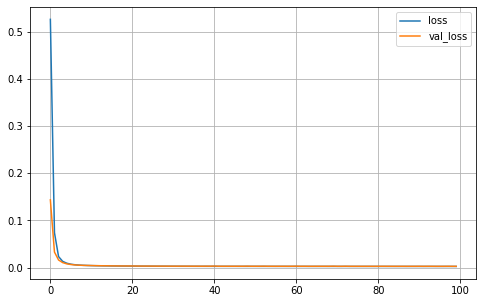

Training time:60.570679903030396
313/313 [==============================] - 0s 532us/step - loss: 0.0023
Test MSE:0.0022567647974938154


In [36]:
from CP_Model import CP_Based
from tensorflow.keras.models import Sequential
from tensorflow import keras 

x_train_processed,x_val_processed,x_test_processed=local_feature_mapping(x_train,x_val,x_test,local_dim=local_dim,unit_norm=True)

model=Sequential()
model.add(CP_Based(units=1,activation=None,cp_rank=cp_rank,local_dim=local_dim,

                    initializer=keras.initializers.TruncatedNormal(mean=0, stddev=0.5)))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

start = time.time()
history=model.fit(x_train_processed, y_train, epochs=100, batch_size=256,validation_data=(x_val_processed,y_val))
end = time.time()
model.summary()

train_loss=min(history.history['loss'])
val_loss=min(history.history['val_loss'])
print('train loss:{}'.format(train_loss))
print('validation loss:{}'.format(val_loss))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

print('Training time:{}'.format(end-start))
print('Test MSE:{}'.format(model.evaluate(x_test_processed,y_test)))



# Deep Kernel

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (50, 27)                  189       
_________________________________________________________________
dense_1 (Dense)              (50, 25)                  700       
_________________________________________________________________
dense_2 (Dense)              (50, 1)                   26        
Total params: 915
Trainable params: 915
Non-trainable params: 0
_________________________________________________________________
Epoch:0, ELBO:-155261.8557036624
Epoch:1000, ELBO:-46395.31957689036
Epoch:2000, ELBO:-3835.4743998066165
Epoch:3000, ELBO:27645.224455221476
Epoch:4000, ELBO:66429.17799085342
Epoch:5000, ELBO:99402.42800015335
Epoch:6000, ELBO:119477.9828344292
Epoch:7000, ELBO:130072.65926632151
Epoch:8000, ELBO:130133.48217006862
Epoch:9000, ELBO:129853.36389822907
Training Time :27.6863379478454

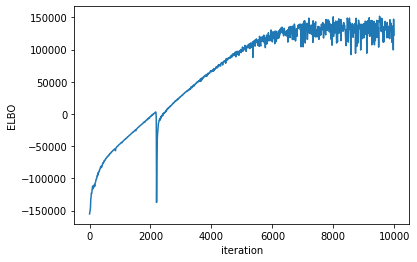

In [37]:
from DeepKernels import DeepKernel, KernelSpaceInducingPoints

batch_size=256
kernel = DeepKernel(gpflow.kernels.SquaredExponential(), batch_size=batch_size)

M=50 # inducing points 

Z=x_train[:M,:].copy()                           
inducing_variable_CP = kernel.CP(Z)
inducing_variable = KernelSpaceInducingPoints(inducing_variable_CP)

model= gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable , num_data=x_train.shape[0])    
gpflow.set_trainable(model.inducing_variable, True)
model.kernel.CP.summary()

# Training

iterations = ci_niter(10000)

logf = []

train_iter=iter(train_dataset)
training_loss = model.training_loss_closure(train_iter,compile=True)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)
start=time.time()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
    
for step in range(iterations):
    optimization_step()    
    if step % 10 == 0:
        elbo = -training_loss().numpy()
        logf.append(elbo)
    if step % 1000==0:
        print("Epoch:{}, ELBO:{}".format(step,model.elbo(data=(x_train,y_train)))) 

end=time.time()
print("Training Time :{}".format(end-start))

plt.plot(np.arange(iterations)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

train_mean, train_var = model.predict_f(x_train) 
train_elbo=model.elbo(data=(x_train,y_train))

train_mse=tf.reduce_mean(tf.losses.MSE(train_mean,y_train))

val_mean, val_var = model.predict_f(x_val)
val_elbo = model.elbo(data=(x_val,y_val))

val_mse=tf.reduce_mean(tf.losses.MSE(val_mean,y_val))

test_mean, val_var = model.predict_f(x_test)
test_elbo = model.elbo(data=(x_test,y_test))

test_mse=tf.reduce_mean(tf.losses.MSE(test_mean,y_test))


print("Train MSE:{}, Train ELBO:{}".format(train_mse,train_elbo))
print("Validation MSE:{}, Validation ELBO:{}".format(val_mse,val_elbo))
print("Test MSE:{}, Validation ELBO:{}".format(test_mse,test_elbo))

# Gaussian Process with ARD RBF Kernel 

Train MSE:0.0034448024019550823, Train ELBO:107106.16782397758
Validation MSE:0.0035784479772175185, Validation ELBO:106107.00263121004
Test MSE:0.0034544910353229226, Validation ELBO:107072.42284413292


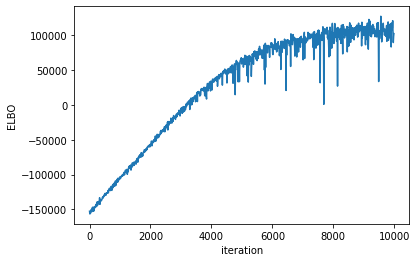

In [38]:
kernel= gpflow.kernels.SquaredExponential(lengthscales=[0.1]*x_train.shape[1]) #  ARD

M=50 # inducing points 

# Cluster Initialization of Inducing Points 
inducing_variable_kmeans = KMeans(n_clusters=M,random_state=0).fit(x_train)   
Z=inducing_variable_kmeans.cluster_centers_    

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=x_train.shape[0])
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(x_train.shape[0])

minibatch_size = 256
gpflow.set_trainable(model.inducing_variable, True)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=1e-3)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

maxiter = ci_niter(10000)

logf = run_adam(model, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

train_mean, train_var = model.predict_f(x_train) 
train_elbo=model.elbo(data=(x_train,y_train))

train_mse=tf.reduce_mean(tf.losses.MSE(train_mean,y_train))

val_mean, val_var = model.predict_f(x_val)
val_elbo = model.elbo(data=(x_val,y_val))

val_mse=tf.reduce_mean(tf.losses.MSE(val_mean,y_val))

test_mean, val_var = model.predict_f(x_test)
test_elbo = model.elbo(data=(x_test,y_test))

test_mse=tf.reduce_mean(tf.losses.MSE(test_mean,y_test))


print("Train MSE:{}, Train ELBO:{}".format(train_mse,train_elbo))
print("Validation MSE:{}, Validation ELBO:{}".format(val_mse,val_elbo))
print("Test MSE:{}, Validation ELBO:{}".format(test_mse,test_elbo))